## German Traffic Sign Recognition Classifier
- National Cheng Kung University Electrical Engineering
- Student: Eason Chen
- ID: E24094198
- Goal: Try to train a LaNet5 for recognizing German traffic sign, and then test the model with some online found German traffic sign images

### Step 0: Load the Data stored in p-coded file

In [1]:
# load data using pickle
import pickle

train_file='./traffic-signs-data/train.p'
valid_file='./traffic-signs-data/valid.p'
test_file='./traffic-signs-data/test.p'

with open(train_file, mode='rb') as f:
    train=pickle.load(f)
with open(valid_file, mode='rb') as f:
    valid=pickle.load(f)
with open(test_file, mode='rb') as f:
    test=pickle.load(f)

x_train, y_train=train['features'], train['labels']
x_valid, y_valid=valid['features'], valid['labels']
x_test, y_test=test['features'], test['labels']

### Step 1: Dataset Summary & Exploration

#### Show the basic info of images and dataset

In [2]:
# show some basic dataset informations
import numpy as np

# count of training data, testing data and validation data
n_train=x_train.shape[0]
n_valid=x_valid.shape[0]
n_test=x_test.shape[0]

# shape of a traffic sign image
image_shape=x_train.shape[1:]

# count of classes in the dataset
n_classes=len(np.unique(y_train))

print(f'Count of training data: {n_train}')
print(f'Count of validation data: {n_valid}')
print(f'Count of testing data: {n_test}')
print(f'Image shape: {image_shape}')
print(f'Count of classes: {n_classes}')

Count of training data: 34799
Count of validation data: 4410
Count of testing data: 12630
Image shape: (32, 32, 3)
Count of classes: 43


#### Randomly show several classes of traffic signs

[( 0, b'Speed limit (20km/h)') ( 1, b'Speed limit (30km/h)')
 ( 2, b'Speed limit (50km/h)') ( 3, b'Speed limit (60km/h)')
 ( 4, b'Speed limit (70km/h)') ( 5, b'Speed limit (80km/h)')
 ( 6, b'End of speed limit (80km/h)') ( 7, b'Speed limit (100km/h)')
 ( 8, b'Speed limit (120km/h)') ( 9, b'No passing')
 (10, b'No passing for vehicles over 3.5 metric tons')
 (11, b'Right-of-way at the next intersection') (12, b'Priority road')
 (13, b'Yield') (14, b'Stop') (15, b'No vehicles')
 (16, b'Vehicles over 3.5 metric tons prohibited') (17, b'No entry')
 (18, b'General caution') (19, b'Dangerous curve to the left')
 (20, b'Dangerous curve to the right') (21, b'Double curve')
 (22, b'Bumpy road') (23, b'Slippery road')
 (24, b'Road narrows on the right') (25, b'Road work')
 (26, b'Traffic signals') (27, b'Pedestrians') (28, b'Children crossing')
 (29, b'Bicycles crossing') (30, b'Beware of ice/snow')
 (31, b'Wild animals crossing')
 (32, b'End of all speed and passing limits') (33, b'Turn right a

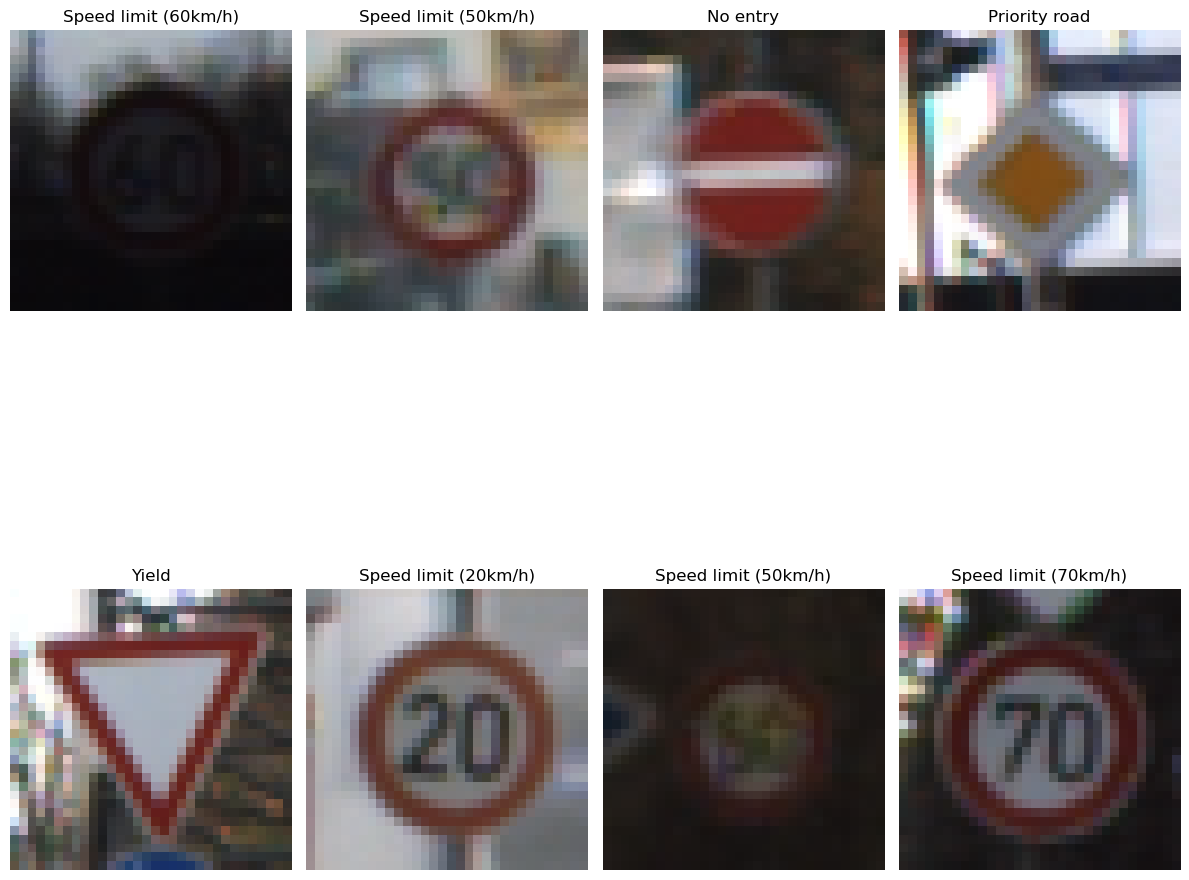

In [3]:
# randomly show different types of traffic sign with corresponding class name
import matplotlib.pyplot as plt
%matplotlib inline
import random

def plot_figures(figures, n_rows=1, n_cols=1, labels=None):
    fig, axes=plt.subplots(ncols=n_cols, nrows=n_rows, figsize=(12,14))
    axes=axes.ravel()
    for index, title in zip(range(len(figures)), figures):
        axes[index].imshow(figures[title], plt.gray())
        if labels!=None:
            axes[index].set_title(labels[index])
        else:
            axes[index].set_title(title)
        axes[index].set_axis_off()
    plt.tight_layout()

name_values=np.genfromtxt('signnames.csv', skip_header=1, dtype=[('myint','i8'),('mtstring','S55')], delimiter=',')
print(name_values)

count_to_show=8
figures={}
labels={}
random_signs=[] # record the random picked images' indices
for i in range(count_to_show):
    index=random.randint(0, n_train-1)
    labels[i]=name_values[y_train[index]][1].decode('ascii')
    figures[i]=x_train[index]
    random_signs.append(index)

plot_figures(figures, 2, 4, labels)

#### Show the class distribution in each dataset

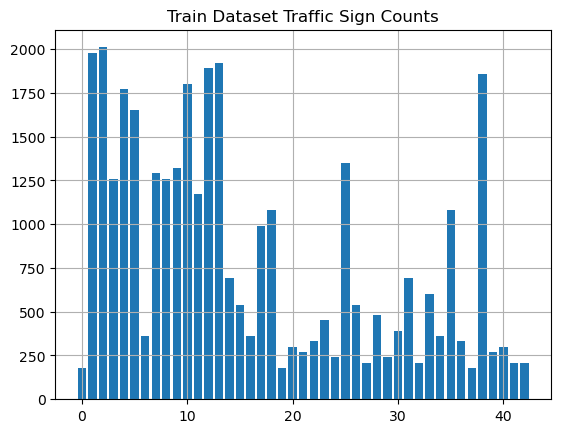

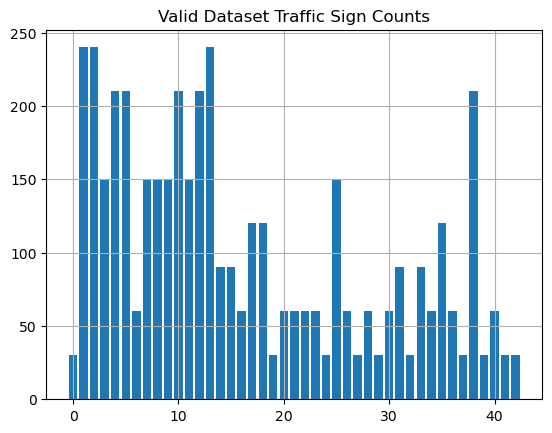

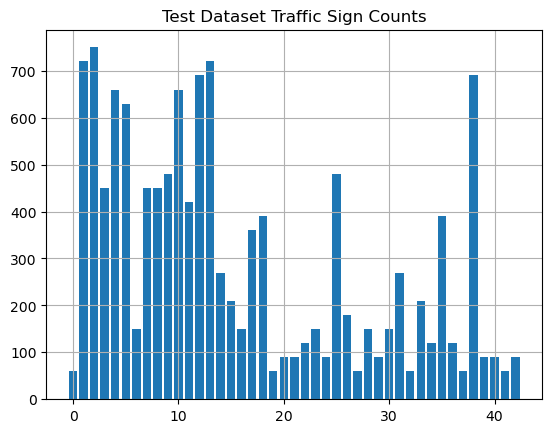

In [4]:
unique_train, counts_train=np.unique(y_train, return_counts=True)
plt.bar(unique_train, counts_train)
plt.grid()
plt.title('Train Dataset Traffic Sign Counts')
plt.show()

unique_valid, counts_valid=np.unique(y_valid, return_counts=True)
plt.bar(unique_valid, counts_valid)
plt.grid()
plt.title('Valid Dataset Traffic Sign Counts')
plt.show()

unique_test, counts_test=np.unique(y_test, return_counts=True)
plt.bar(unique_test, counts_test)
plt.grid()
plt.title('Test Dataset Traffic Sign Counts')
plt.show()

### Step 2: Preprocess Dataset(including normalize, grayscale, data_augmentation...)

#### Convert Images to Grayscale

In [5]:
# preprocess dataset (including normalization, converting to grayscale...)
x_train_RGB=x_train
x_train_gray=np.sum(x_train/3, axis=3, keepdims=True)

x_valid_RGB=x_valid
x_valid_gray=np.sum(x_valid/3, axis=3, keepdims=True)

x_test_RGB=x_test
x_test_gray=np.sum(x_test/3, axis=3, keepdims=True)

print(f'x_train_RGB shape: {x_train_RGB.shape}')
print(f'x_train_gray shape: {x_train_gray.shape}')

x_train_RGB shape: (34799, 32, 32, 3)
x_train_gray shape: (34799, 32, 32, 1)


In [6]:
x_train=x_train_gray
x_valid=x_valid_gray
x_test=x_test_gray

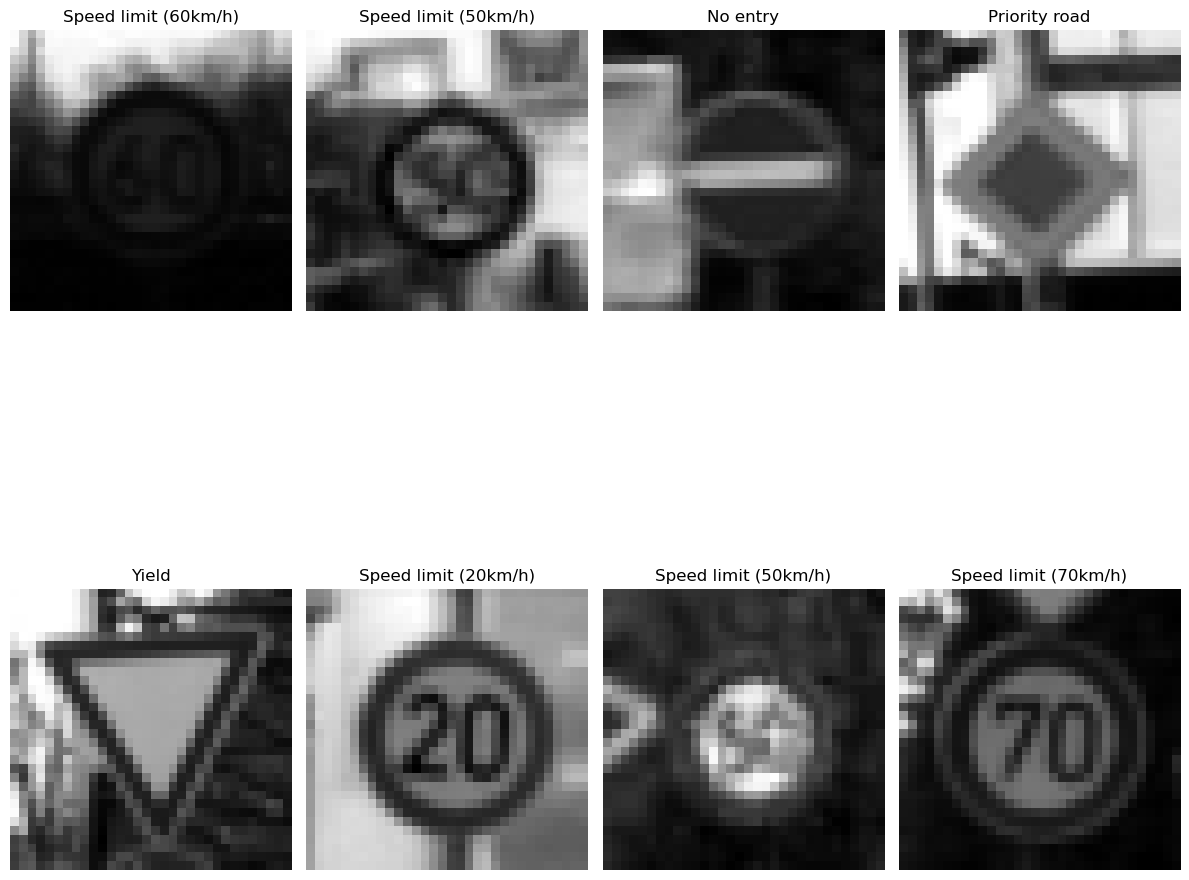

In [7]:
count_to_show=8
figures={}
count=0
for i in random_signs:
    labels[count]=name_values[y_train[i]][1].decode('ascii')
    figures[count]=x_train[i].squeeze()
    count+=1

plot_figures(figures, 2, 4, labels)

#### Data Augmentation for More Training Data(Affine/Perspective)

In [8]:
import cv2

# apply Affine tranformation and Perspective transformation and Rotation for Data Augmentation
affine_x=[]
affine_y=[]
perspective_x=[]
perspective_y=[]
rotate_x=[]
rotate_y=[]
new_counts_train=counts_train

# start apply data augmentation
for i in range(n_train):
    if(new_counts_train[y_train[i]]<5000):
        for j in range(3):
            # Affine Transformation(random translation)
            dx, dy=np.random.randint(-1.7, 1.8, 2)
            M=np.float32([[1, 0, dx],[0, 1, dy]])
            dst=cv2.warpAffine(x_train[i], M, (x_train[i].shape[0], x_train[i].shape[1]))
            dst=dst[:,:,None]
            affine_x.append(dst)
            affine_y.append(y_train[i])

            # Perspective Transformation
            high_bound=random.randint(22, 32)
            low_bound=random.randint(0, 12)
            points_one=np.float32([[0,0], [32,0], [0,32], [32,32]])
            points_two=np.float32([[0,0], [high_bound, low_bound], [low_bound, 32], [32, high_bound]])
            M=cv2.getPerspectiveTransform(points_one, points_two)
            dst=cv2.warpPerspective(x_train[i], M, (32, 32))
            perspective_x.append(dst)
            perspective_y.append(y_train[i])

            # Rotation
            tilt=random.randint(-15, 15)
            M=cv2.getRotationMatrix2D((x_train[i].shape[0]/2, x_train[i].shape[1]/2), tilt, 1)
            dst=cv2.warpAffine(x_train[i], M, (x_train[i].shape[0], x_train[i].shape[1]))
            rotate_x.append(dst)
            rotate_y.append(y_train[i])

            new_counts_train[y_train[i]]+=2

# convert to numpy array and reshape if necessary
affine_x=np.array(affine_x)
affine_y=np.array(affine_y)
perspective_x=np.array(perspective_x)
perspective_x=np.reshape(perspective_x, (np.shape(perspective_x)[0], 32, 32, 1))
perspective_y=np.array(perspective_y)
rotate_x=np.array(rotate_x)
rotate_x=np.reshape(rotate_x, (np.shape(rotate_x)[0], 32, 32, 1))
rotate_y=np.array(rotate_y)

# concatenate the augmented dataset into original data
x_train=np.concatenate((x_train, affine_x), axis=0)
x_train=np.concatenate((x_train, perspective_x), axis=0)
x_train=np.concatenate((x_train, rotate_x), axis=0)
y_train=np.concatenate((y_train, affine_y), axis=0)
y_train=np.concatenate((y_train, perspective_y), axis=0)
y_train=np.concatenate((y_train, rotate_y), axis=0)

# Since we have some augmented data within dataset, so the validation dataset should also contain some of augmented data
# so we combine the valid dataset and train dataset temporarily
# and use train_test_split to seperate the dataset later
x_train=np.concatenate((x_train, x_valid), axis=0)
y_train=np.concatenate((y_train, y_valid), axis=0)


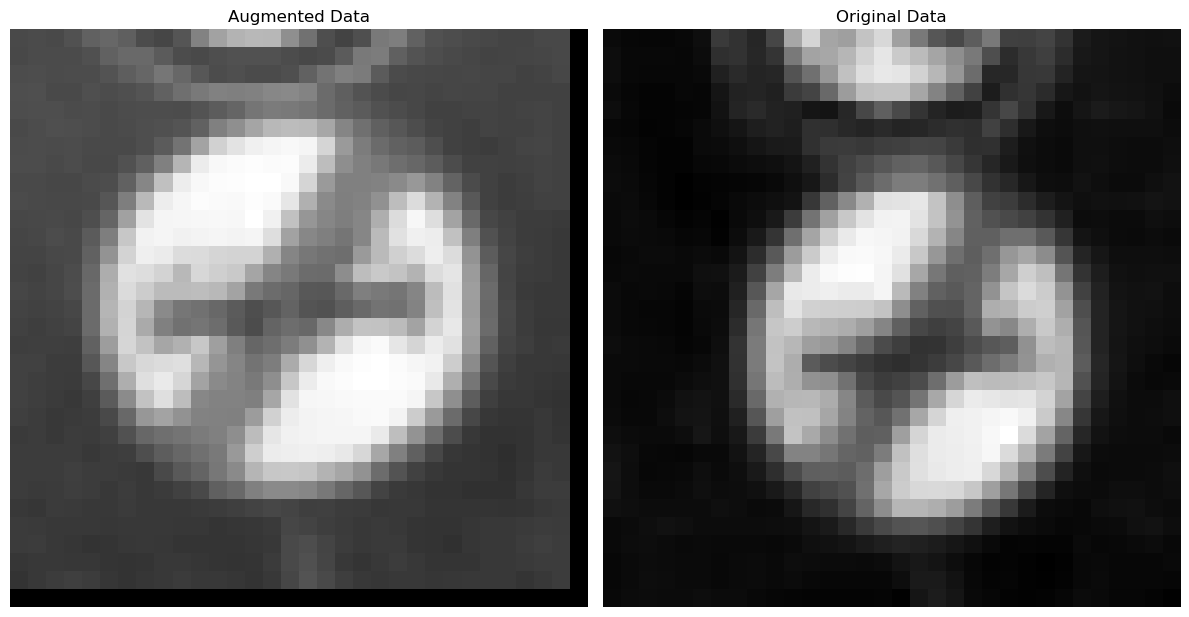

In [9]:
# display the augmented data compared with the orginal data
figure={}
label={}
figure[0]=x_train[n_train+50].squeeze()
label[0]="Augmented Data"
figure[1]=x_train[0].squeeze()
label[1]="Original Data"

plot_figures(figure, 1, 2, label)

#### Apply CLAHE (Contrast Limited Adaptive Histogram Equalization) to Increase the Contrast

In [10]:
# use the cv2 CLAHE function to increase contrast in training and validation dataset
def CLAHE(dataset):
    enhanced_images=[]
    for image in dataset:
        if len(image.shape) == 3 and image.shape[2] == 1:
            image = np.squeeze(image)  # Remove singleton channel dimension
        # Ensure image is in the correct data type (8-bit)
        if image.dtype != np.uint8:
            image = image.astype(np.uint8)
        CLAHE=cv2.createCLAHE(clipLimit=2.0, tileGridSize=(4,4))
        result=CLAHE.apply(image)
        enhanced_images.append(result)
    return np.array(enhanced_images)

# apply CLAHE
x_train=CLAHE(x_train)
x_test=CLAHE(x_test)

#### Apply train_test_split to split validation dataset from training dataset

New Dataset Size : 168289


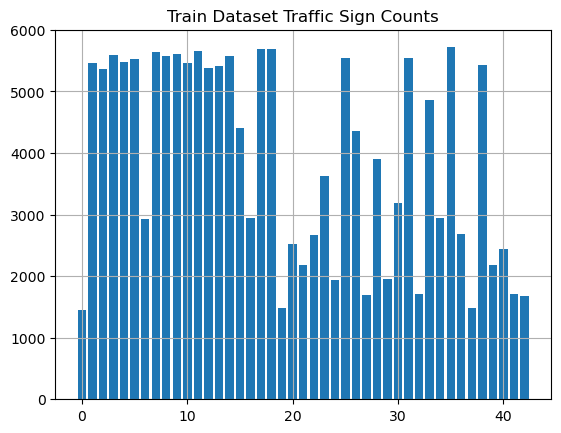

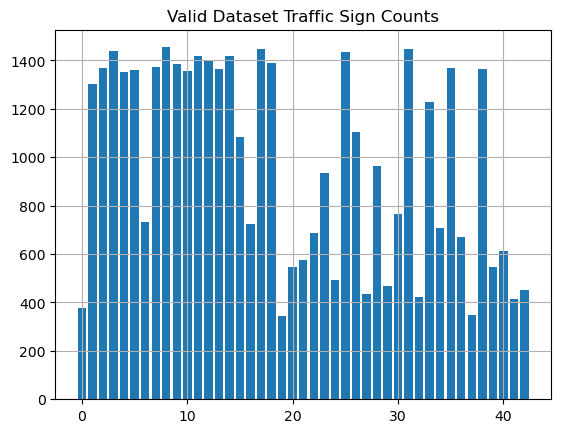

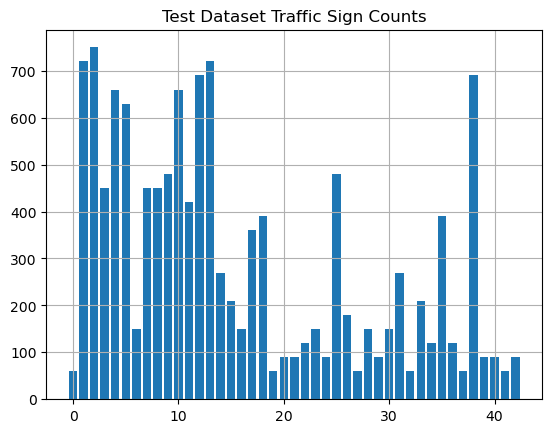

In [11]:
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

print("New Dataset Size : {}".format(x_train.shape[0]))

unique, counts = np.unique(y_train, return_counts=True)
plt.bar(unique, counts)
plt.grid()
plt.title("Train Dataset Traffic Sign Counts")
plt.show()

unique, counts = np.unique(y_valid, return_counts=True)
plt.bar(unique, counts)
plt.grid()
plt.title("Valid Dataset Traffic Sign Counts")
plt.show()

unique, counts = np.unique(y_test, return_counts=True)
plt.bar(unique, counts)
plt.grid()
plt.title("Test Dataset Traffic Sign Counts")
plt.show()


#### Normalize the Dataset

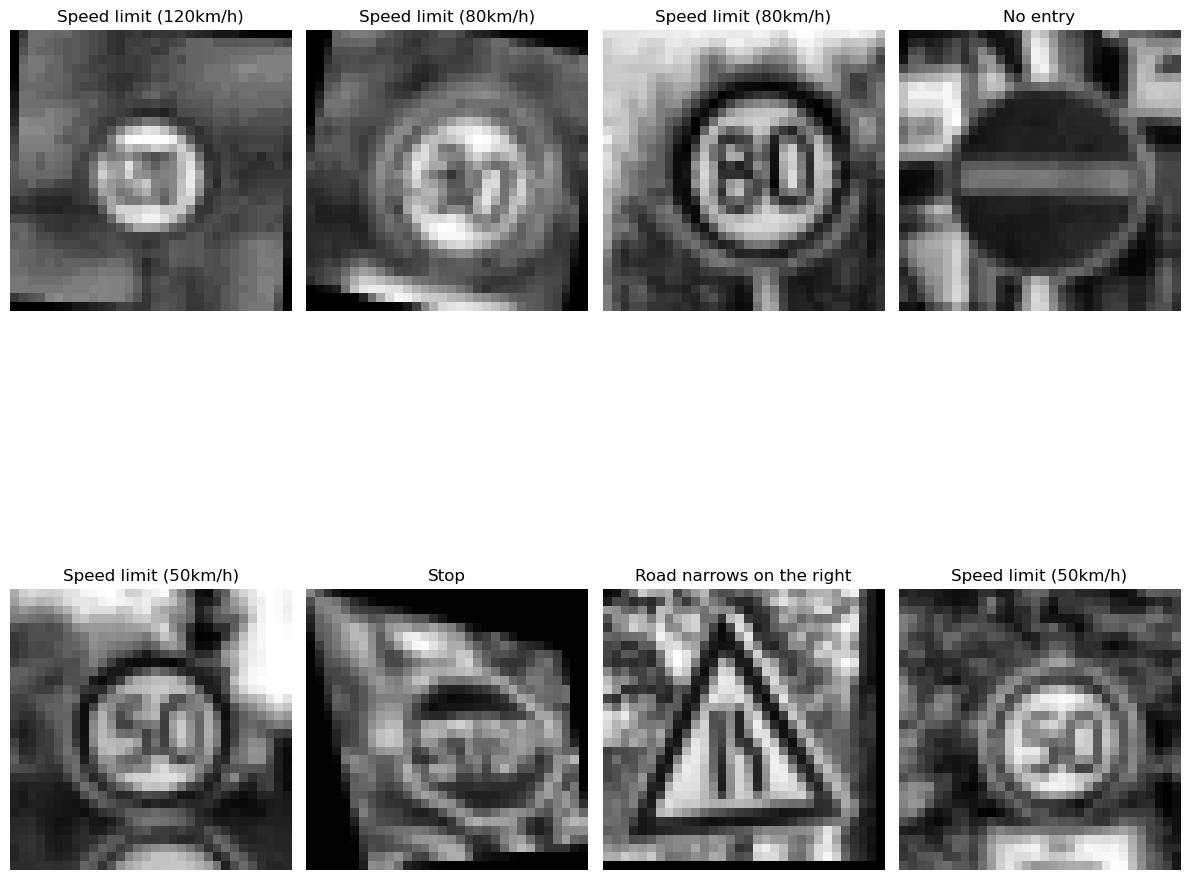

In [12]:
# divided by 127.5 -> let the pixel value between 0~2, since the original pixel value is 255
# minus by 1 -> let the pixel value between -1~1
x_train_normalized=x_train/127.5-1
x_valid_normalized=x_valid/127.5-1
x_test_normalized=x_test/127.5-1

count_to_show=8
figures={}
count=0
for i in random_signs:
    labels[count]=name_values[y_train[i]][1].decode('ascii')
    figures[count]=x_train_normalized[i].squeeze()
    count+=1

plot_figures(figures, 2, 4, labels)

In [13]:
# re-assign normalized dataset to original dataset
x_train=x_train_normalized
x_valid=x_valid_normalized
x_test=x_test_normalized

### Step 3: Design LeNet5 Model for Training and Validation

#### Building LeNet5 Model based on Definition

In [14]:
from tensorflow.keras import layers, models

model=models.Sequential()
# Conv 32x32x1 -> 28x28x6
model.add(layers.Conv2D(filters=6, kernel_size=(5,5),strides=(1,1),padding='valid',activation='relu',data_format='channels_last',input_shape=(32,32,1)))
# Maxpool 28x28x6 -> 14x14x6
model.add(layers.MaxPooling2D((2,2)))
# Conv 14x14x6 -> 10x10x6
model.add(layers.Conv2D(16,(5,5),activation='relu'))
# Maxpool 10x10x6 -> 5x5x16
model.add(layers.MaxPooling2D((2,2)))
# Flatten 5x5x16 -> 400
model.add(layers.Flatten())
# Full connect 400 -> 120
model.add(layers.Dense(120,activation='relu'))
# Full connect 120 -> 84
model.add(layers.Dense(84,activation='relu'))
model.add(layers.Dropout(0.2))
# Fully connect output 43 classes(due to 43 classes in German Traffic Signs)
model.add(layers.Dense(43,activation='softmax'))


# show the summary of model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 6)         156       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 6)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 16)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 400)               0         
                                                                 
 dense (Dense)               (None, 120)               4

#### Training Model and Evaluation

In [15]:
# setup Early-Stopping criteria
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(factor=0.1, patience=3)

# import different optimizers
from keras.optimizers import Adam, Adagrad, RMSprop, SGD
optimizer_Adam=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
optimizer_RMSProp = RMSprop(learning_rate=0.001, rho=0.9, momentum=0.0, epsilon=1e-07, centered=False)
# optimizer_Adagrad = Adagrad(learning_rate=0.01, initial_accumulator_value=0.1, epsilon=1e-07)
optimizer_SGD = SGD(learning_rate=0.001, momentum=0.9, decay=1e-6, nesterov=False)

# specify optimizer, loss function and metric
model.compile(optimizer=optimizer_Adam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# start training with specified batch_size and epochs
batch_size=128
epochs=200

LeNet5=model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_valid, y_valid), callbacks=[early_stopping])

Epoch 1/200
1315/1315 [==============================] - 16s 12ms/step - loss: 1.0634 - accuracy: 0.7027 - val_loss: 0.4138 - val_accuracy: 0.8807
Epoch 2/200
1315/1315 [==============================] - 23s 18ms/step - loss: 0.3764 - accuracy: 0.8871 - val_loss: 0.2459 - val_accuracy: 0.9280
Epoch 3/200
1315/1315 [==============================] - 12s 9ms/step - loss: 0.2576 - accuracy: 0.9208 - val_loss: 0.1863 - val_accuracy: 0.9434
Epoch 4/200
1315/1315 [==============================] - 12s 9ms/step - loss: 0.2009 - accuracy: 0.9379 - val_loss: 0.1575 - val_accuracy: 0.9527
Epoch 5/200
1315/1315 [==============================] - 12s 9ms/step - loss: 0.1662 - accuracy: 0.9474 - val_loss: 0.1388 - val_accuracy: 0.9574
Epoch 6/200
1315/1315 [==============================] - 12s 9ms/step - loss: 0.1409 - accuracy: 0.9552 - val_loss: 0.1282 - val_accuracy: 0.9608
Epoch 7/200
1315/1315 [==============================] - 13s 10ms/step - loss: 0.1261 - accuracy: 0.9597 - val_loss: 0.115

#### Output the Trainging and Validation Related Curves & Confusion Matrix

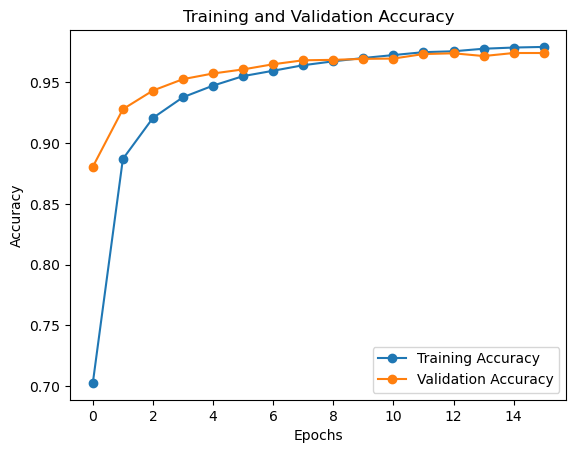

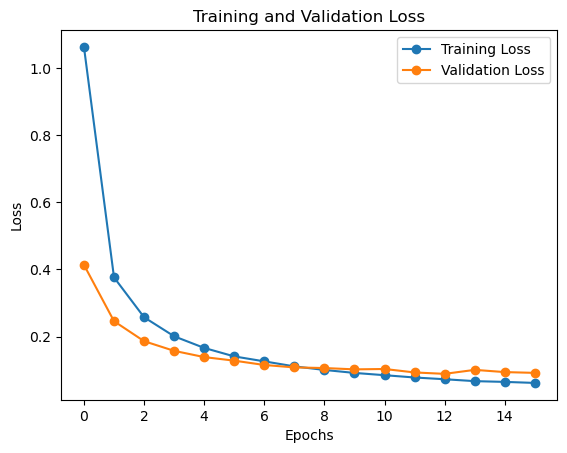

In [16]:
# plot accuracy curves
plt.plot(LeNet5.history['accuracy'], '-o')
plt.plot(LeNet5.history['val_accuracy'], '-o')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')
plt.show()

# plot loss curves
plt.plot(LeNet5.history['loss'], '-o')
plt.plot(LeNet5.history['val_loss'], '-o')
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.show()

395/395 [==============================] - 1s 2ms/step


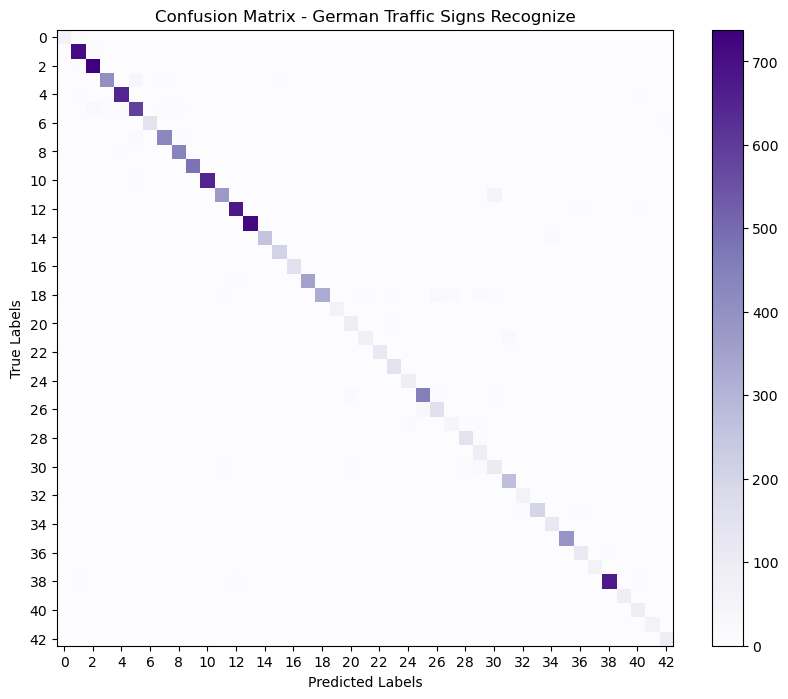

In [17]:
# show the confusion matrix
from sklearn.metrics import confusion_matrix

y_pred=model.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)
cm=confusion_matrix(y_test, y_pred_labels)
plt.figure(figsize=(10,8))
plt.imshow(cm, cmap='Purples', interpolation='nearest')
plt.colorbar()
plt.title('Confusion Matrix - German Traffic Signs Recognize')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(np.arange(0, 43, step=2))
plt.yticks(np.arange(0, 43, step=2))
plt.show()

In [18]:
# Show the classification report
from sklearn.metrics import classification_report

y_pred=model.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)
report=classification_report(y_test, y_pred_labels)
print(report)

395/395 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       0.96      0.92      0.94        60
           1       0.97      0.99      0.98       720
           2       0.97      0.98      0.98       750
           3       0.98      0.90      0.94       450
           4       0.97      0.98      0.97       660
           5       0.91      0.93      0.92       630
           6       0.98      0.97      0.97       150
           7       0.97      0.95      0.96       450
           8       0.96      0.98      0.97       450
           9       0.99      1.00      0.99       480
          10       1.00      0.98      0.99       660
          11       0.96      0.88      0.92       420
          12       0.98      0.98      0.98       690
          13       1.00      0.99      1.00       720
          14       0.99      0.95      0.97       270
          15       0.97      0.98      0.98       210
          16       1.00   

### Step 4: Test Model on New Images

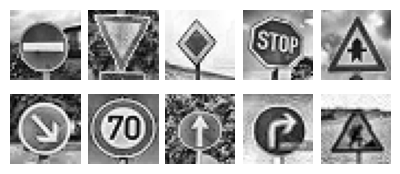

In [19]:
# Load the images from the testImages directory
import glob
import matplotlib.image as mpimg

fig, axes=plt.subplots(2,5,figsize=(5,2))
fig.subplots_adjust(hspace=0.2, wspace=0.01)
axes=axes.ravel()

test_images=[]
for i, img in enumerate(glob.glob('./testImages/*.png')):
    image=cv2.imread(img)
    axes[i].axis('off')
    test_images.append(image)

test_images=np.array(test_images)

# convert to grayscale
test_images=np.sum(test_images/3, axis=3, keepdims=True)

# apply CLAHE to test images
test_images=CLAHE(test_images)

# normalize the test images
test_images=test_images/127.5-1

for i in range(10):  # Adjusted index range
    axes[i].imshow(test_images[i].squeeze())  # Squeezed to remove channel dimension for grayscale


In [20]:
# Based on the signnames.csv, provide the 10 test images' labels
test_labels=[17,13,12,14,11,38,4,35,33,25]

# evaluate the accuracy
result=np.argmax(model.predict(test_images), axis=1)
print(f'predict label: {result}')
print()
accuracy=model.evaluate(test_images, np.array(test_labels))

1/1 [==============================] - 0s 26ms/step
predict label: [17 13 12 14 11 38  4 35 33 30]

1/1 [==============================] - 0s 126ms/step - loss: 1.0591 - accuracy: 0.9000
